In [1]:
import os
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

from lammps_implicit_der.systems import BccBinary
from lammps_implicit_der import SNAP
from lammps_implicit_der.tools import error_tools, plot_tools

## Define a non-perturbed random alloy system

In [2]:
num_cells = 2

## Nickel-Molybdenum random alloy system

In [18]:
# Check if the bcc_random.data file exists
datafilename = 'bcc_random.data'
datafile = datafilename if os.path.exists(datafilename) else None

#datafile = None

bcc_alloy_Ni_Mo = BccBinary(datafile=datafile,
                                  snapcoeff_filename='NiMo.snapcoeff',
                                  num_cells=num_cells,
                                  specie_B_concentration=0.5,
                                  minimize=True)

if datafile is None:
    bcc_alloy_Ni_Mo.write_data(datafilename)

None
Running LAMMPS with the following arguments:
-screen none -log none
Reading datafile bcc_random.data
Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg
Number of atoms: 16, largest force value: 2.257e-09, force norm: 5.999e-09


In [19]:
print(bcc_alloy_Ni_Mo.pot.Theta_dict['Mo'])

{'elem_params': {'radius': 0.575, 'weight': 1.0}, 'beta0': -11.1413071988, 'Theta': array([ 0.00217993,  0.02117406,  0.05027489,  0.01271017,  0.32806724,
        0.06901471,  0.1782036 ,  0.00128021,  0.06856159,  0.02934277,
        0.0085863 , -0.00900972,  0.00302195,  0.02371238,  0.00319153,
        0.03359465,  0.06278455, -0.06161855, -0.02141344, -0.0348541 ,
        0.01435036,  0.00391291,  0.02266774, -0.02309605, -0.02843036,
        0.00857356,  0.00335881,  0.03927386, -0.00041452, -0.00370094])}


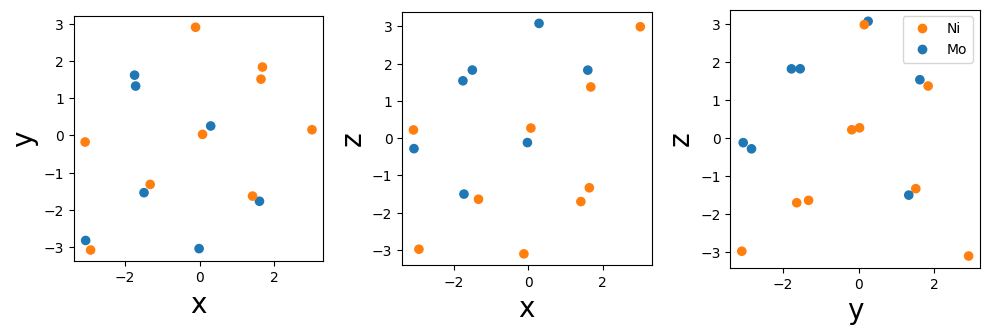

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
specie_color = {1: 'tab:orange', 2: 'tab:blue'}
specie_colors = [specie_color[s] for s in bcc_alloy_Ni_Mo.species]
plot_tools.plot_coords(axes, bcc_alloy_Ni_Mo.X_coord.reshape(-1, 3), c=specie_colors, s=35)
plt.tight_layout()
plot_tools.setup_color_legend(axes[2], list(specie_color.values()), bcc_alloy_Ni_Mo.pot.elem_list)
plt.show()

In [21]:
print(bcc_alloy_Ni_Mo.species)

[1 1 1 2 2 2 2 2 2 1 1 2 1 1 1 1]


## Pure Nickel bcc lattice

In [22]:
# Check if the bcc_random.data file exists
datafilename = 'bcc_Ni.data'
datafile = datafilename if os.path.exists(datafilename) else None

#datafile = None

bcc_Ni = BccBinary(datafile=None,
                    snapcoeff_filename='NiMo.snapcoeff',
                    num_cells=num_cells,
                    specie_B_concentration=0.0,
                    minimize=True)

None
Running LAMMPS with the following arguments:
-screen none -log none
Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg
Number of atoms: 16, largest force value: 1.301e-15, force norm: 4.296e-15


In [23]:
print(bcc_Ni.species)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


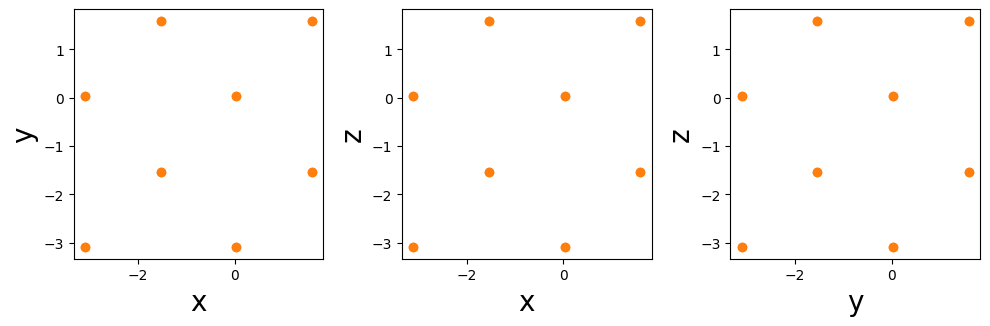

In [24]:
X_coord_bcc = bcc_Ni.X_coord.copy()
X_coord_bcc = X_coord_bcc.reshape(-1, 3)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plot_tools.plot_coords(axes, X_coord_bcc, c='tab:orange', s=35)
plt.tight_layout()
plt.show()

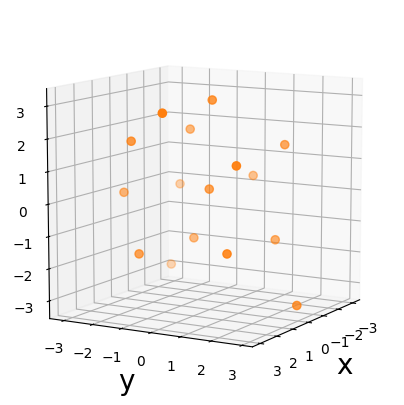

In [26]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d', proj_type='persp') # 'ortho' or 'persp'
ax.view_init(elev=10, azim=30)
plot_tools.plot_coords_3D(ax, bcc_alloy_Ni_Mo.X_coord.reshape(-1, 3), c='tab:orange', s=35)

## Perturbed parameters $\Theta'(\delta) = (1-\delta) \times \Theta^{\mathrm{Ni}} + \delta \times \Theta^{\mathrm{Mo}}$

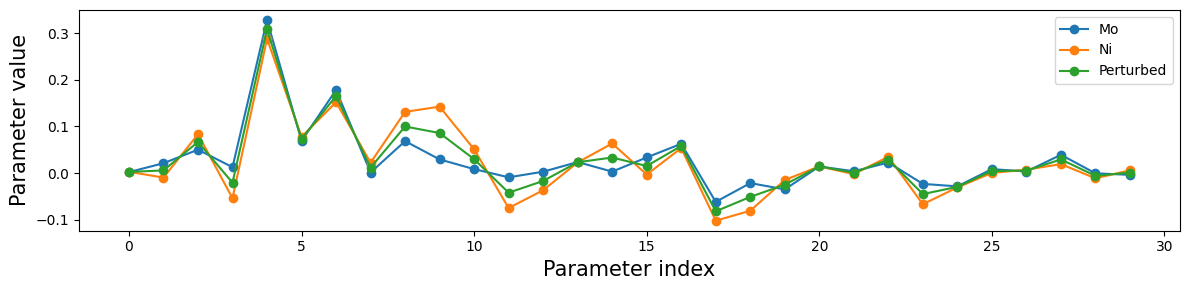

In [27]:
def get_perturbed_Theta(Theta1, Theta2, delta):
    # delta = 0.0 -> Theta1
    return (1.0 - delta) * Theta1 + delta * Theta2

# Molybdenum Theta parameters
Theta_Mo = bcc_alloy_Ni_Mo.pot.Theta_dict['Mo']['Theta'].copy()

# Nickel Theta parameters
Theta_Ni = bcc_alloy_Ni_Mo.pot.Theta_dict['Ni']['Theta'].copy()

# Perturbed Theta parameters 'in between' Ni and Mo
Theta_perturbed = get_perturbed_Theta(Theta_Ni, Theta_Mo, 0.5)

fig, ax = plt.subplots(1, 1, figsize=(12, 3))

ax.plot(Theta_Mo, marker='o', ls='-', label='Mo')
ax.plot(Theta_Ni, marker='o', ls='-', label='Ni')
ax.plot(Theta_perturbed, marker='o', ls='-', label='Perturbed')

ax.set_xlabel('Parameter index', fontsize=15)
ax.set_ylabel('Parameter value', fontsize=15)

plt.legend()
plt.tight_layout()
plt.show()

## Ni-$\delta$ Mo alloy system: $\Theta^{\mathrm{Ni}}_0, \Theta'(\delta)$.

In [28]:
def get_bcc_alloy_Ni_delta_Mo(delta, num_cells=2, minimize=False, datafile=None, specie_B_concentration=0.5):

    # Create a normal bcc alloy of Ni and Mo from NiMo.snapcoeff
    bcc_alloy_Ni_delta_Mo = BccBinary(datafile=datafile,
                                    snapcoeff_filename='NiMo.snapcoeff',
                                    num_cells=num_cells,
                                    specie_B_concentration=specie_B_concentration,
                                    minimize=minimize)

    # Molybdenum Theta parameters
    Theta_Mo = bcc_alloy_Ni_Mo.pot.Theta_dict['Mo']['Theta'].copy()

    # Nickel Theta parameters
    Theta_Ni = bcc_alloy_Ni_Mo.pot.Theta_dict['Ni']['Theta'].copy()

    # delta = 0 => Ni
    Theta_perturbed = get_perturbed_Theta(Theta_Ni, Theta_Mo, delta)

    # Set the perturbed Theta parameters
    bcc_alloy_Ni_delta_Mo.pot.Theta_dict['Mo']['Theta'] = Theta_perturbed.copy()

    # Set other parameters of 'delta-Mo' to Ni
    bcc_alloy_Ni_delta_Mo.pot.snapparam_dict = deepcopy(bcc_alloy_Ni_Mo.pot.snapparam_dict)
    bcc_alloy_Ni_delta_Mo.pot.Theta_dict['Mo']['elem_params'] = deepcopy(bcc_alloy_Ni_Mo.pot.Theta_dict['Ni']['elem_params'])
    bcc_alloy_Ni_delta_Mo.pot.Theta_dict['Mo']['beta0'] = bcc_alloy_Ni_delta_Mo.pot.Theta_dict['Ni']['beta0']

    return bcc_alloy_Ni_delta_Mo

bcc_alloy_Ni_delta_Mo = get_bcc_alloy_Ni_delta_Mo(0.5, num_cells=num_cells, minimize=False, datafile=None, specie_B_concentration=0.5)
# Minimize
#bcc_alloy_Ni_delta_Mo.minimize_energy()



None
Running LAMMPS with the following arguments:
-screen none -log none
Number of atoms: 16, largest force value: 4.183e-01, force norm: 1.321e+00


## Compute the perturbed positions from the implicit derivative

In [40]:
bcc_alloy_Ni_Ni = get_bcc_alloy_Ni_delta_Mo(0.0, num_cells=num_cells, minimize=False, datafile=bcc_alloy_Ni_Mo.datafile)
dX_dTheta = bcc_alloy_Ni_Ni.implicit_derivative(method='inverse')

delta = 1.0

Theta_perturbed = get_perturbed_Theta(Theta_Ni, Theta_Mo, delta)

dTheta = Theta_perturbed - Theta_Ni
X_pred = bcc_Ni.X_coord.copy() + dTheta @ dX_dTheta

print(dX_dTheta)


None
Running LAMMPS with the following arguments:
-screen none -log none
Reading datafile bcc_random.data
Number of atoms: 16, largest force value: 2.396e-09, force norm: 8.923e-09


100%|██████████| 48/48 [00:00<00:00, 301.86it/s]

[[ 5.79026167e+00  9.20153635e-01 -2.42023963e+00 ...  2.42539440e+00
   4.12792574e+00 -3.51607589e+00]
 [-1.21889472e-01  4.16272037e-02 -3.85396525e-01 ... -1.75467369e-01
  -8.71485241e-02 -1.64371371e-01]
 [-6.58116265e-02  1.23756266e-02  5.20611323e-02 ...  1.83365417e-03
  -4.29670719e-02  3.80893984e-03]
 ...
 [-2.33923074e+00  4.79287706e-01  1.02314902e+00 ... -5.65971193e-01
  -1.35716050e+00  7.63453645e-01]
 [-1.01279128e+00  1.71230485e+00  6.66548708e-01 ...  1.78345657e+00
   1.30268388e+00 -6.87832463e-01]
 [-5.26206280e+00  3.13858803e+00  4.41292186e+00 ...  1.63447385e+00
  -1.24685798e+00  1.50246848e-01]]


## Get the perturbed positions from the minimization - ground truth.

In [30]:
bcc_alloy_Ni_delta_Mo = get_bcc_alloy_Ni_delta_Mo(delta,
                                                  num_cells=num_cells,
                                                  minimize=True,
                                                  datafile=bcc_alloy_Ni_Mo.datafile,
                                                  specie_B_concentration=0.5)

None
Running LAMMPS with the following arguments:
-screen none -log none
Reading datafile bcc_random.data
Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg
Number of atoms: 16, largest force value: 2.257e-09, force norm: 5.999e-09


## Plot the coordinates

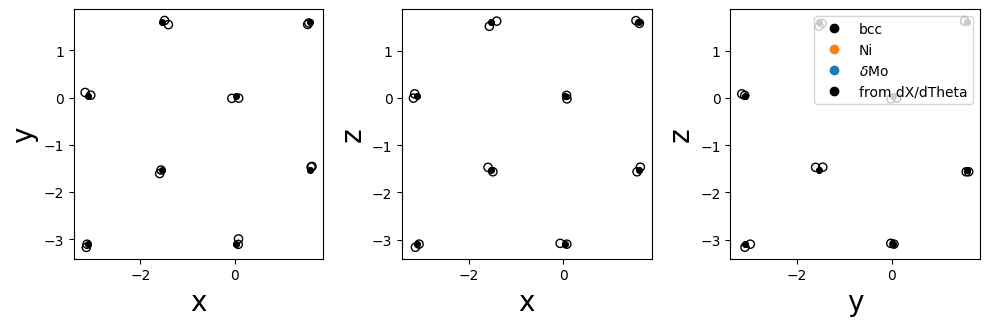

In [39]:

# Plot the perturbed structure
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
color_list = ['black','tab:orange', 'tab:blue', 'black']
label_list = ['bcc', 'Ni', '$\delta$Mo', 'from dX/dTheta']
plot_tools.plot_coords(axes, bcc_Ni.X_coord.reshape(-1, 3), c=color_list[0], s=15)
#plot_tools.plot_coords(axes, bcc_alloy_Ni_delta_Mo.X_coord.reshape(-1, 3), c=specie_colors, s=35)
plot_tools.plot_coords(axes, X_pred.reshape(-1, 3), facecolors='none', s=35, edgecolors='black')

plot_tools.setup_color_legend(axes[2], color_list, label_list, loc='upper right')
plt.tight_layout()
plt.show()

## TODO
* plot as a function of delta
* plot the histogram of dX
* larger systems